In [11]:
%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Saving as a scenario

In [12]:
!ls ../mat/*

../mat/line_fresnelastique.npy ../mat/line_vague_solo.npy
../mat/line_vague_dense.npy    ../mat/master.npy


In [60]:
%%writefile ../scenario_line_master.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np
import os

def master(e, filename):
    if e.structure: N_lame = e.N_lame-e.struct_N
    else: N_lame = e.N_lame

    def montage(z, z_in):
        z_out = z.copy()
        z_s = z_in.copy()
        print (z_out[0, 0], z_out[-1, 0], z_s[0, 0], z_s[-1, 0])
        z_s[:, 0] += z_out[-1, 0] #+ 1./e.desired_fps # increment the time on the new array
        print (z_out.shape, z_s.shape, z_s[0, 0], z_s[-1, 0])
        return np.vstack((z_out, z_s))

    matpath = 'mat/'
    z_s = {}
    for scenario in ['line_vague_dense', 'line_vague_solo', 'line_fresnelastique']:
        z_s[scenario] = np.load(os.path.join(matpath, scenario + '.npy'))
    
    ###########################################################################
    burnout_time = 4.
    z = np.zeros((1, N_lame+1)) # zero at zero
    z = np.vstack((z, np.hstack((np.array(burnout_time), np.zeros(N_lame) ))))
    for _ in range(1):
        ###########################################################################
        z = montage(z, z_s['line_vague_dense'])
        ###########################################################################
        z = montage(z, z_s['line_vague_solo'])
        ###########################################################################
        z = montage(z, z_s['line_fresnelastique'])
        ###########################################################################
        z = montage(z, z_s['line_vague_dense'])
    
    ###########################################################################
    # save the file
    np.save(filename, z)

        

if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
        
    filename='mat/master.npy'
    
    e = el.EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=True, filename=filename)

    if mode == 'writer':
        master(e, filename)
    else:
        # running the code
        el.main(e)


Overwriting ../scenario_line_master.py


In [61]:
%cd ..
%run  scenario_line_master.py writer
%cd posts

/Users/laurentperrinet/pool/Dropbox/py-elasticite
0.0 4.0 0.0 19.8
(2, 26) (595, 26) 4.0 23.8
0.0 23.8 0.0 19.8333333333
(597, 26) (596, 26) 23.8 43.6333333333
0.0 43.6333333333 0.0 119.966666667
(1193, 26) (3600, 26) 43.6333333333 163.6
0.0 163.6 0.0 19.8
(4793, 26) (595, 26) 163.6 183.4
/Users/laurentperrinet/pool/Dropbox/py-elasticite/posts


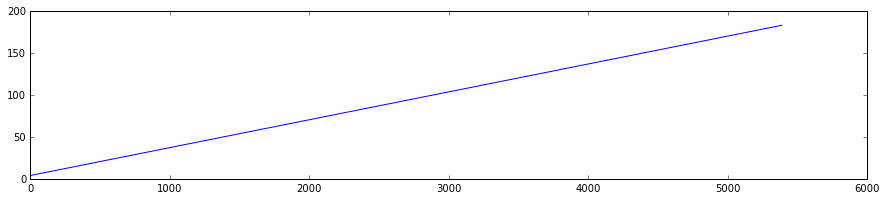

In [62]:
z = np.load('../mat/master.npy')
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(z[:, 0])

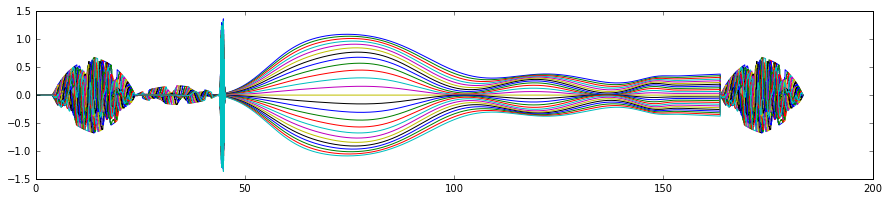

In [63]:
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(z[:, 0], z[:, 1:])

## git


In [45]:
#! git add 2015-11-26*
!git s

 M ../mat/line_fresnelastique.npy
 M ../mat/line_vague_dense.npy
 M ../mat/line_vague_solo.npy
 M ../mat/master.npy
 M "2015-10-14 \303\251lasticit\303\251, Fresnel.ipynb"
 M "2015-11-26 \303\251lasticit\303\251 - sc\303\251nario montage.ipynb"
 M "2015-11-26 \303\251lasticit\303\251 - sc\303\251nario vague.ipynb"
 M ../scenario_line_elastic_fresnel.py
 M ../scenario_line_master.py
 M ../scenario_line_vague.py
?? ../.gitignore_conflict-20151125-105937
?? "2015-11-02 \303\251lasticit\303\251 expansion en miroir - exploration param\303\250tres_conflict-20151125-105824.ipynb"
?? "2015-11-02 \303\251lasticit\303\251 expansion en miroir - principes_conflict-20151123-174335.ipynb"
?? "2015-11-17 \303\251lasticit\303\251 expansion en miroir - dynamique d'un point focal2.ipynb"
?? "2015-11-17 \303\251lasticit\303\251 expansion en miroir - dynamique d'un point focal_conflict-20151123-174338.ipynb"
?? ../scenario_line_fresnel_conflict-20151123-162407.py
?? ../src/elasticite_conflict-20151123-173

In [46]:
!git commit -am' scenario master '

[master d5d8bdd]  scenario master
 10 files changed, 1112 insertions(+), 1254 deletions(-)
 rewrite mat/line_fresnelastique.npy (90%)
 rewrite mat/line_vague_dense.npy (98%)
 rewrite mat/master.npy (85%)
 rewrite "posts/2015-11-26 \303\251lasticit\303\251 - sc\303\251nario montage.ipynb" (92%)


In [47]:
! git push

Counting objects: 14, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (14/14), done.
Writing objects: 100% (14/14), 1.83 MiB | 636.00 KiB/s, done.
Total 14 (delta 9), reused 0 (delta 0)
To git@git.framasoft.org:laurentperrinet/elasticte.git
   76f4ecd..d5d8bdd  master -> master
